Importing libraries

In [ ]:
import pandas as pd
import ast
import re
import emoji
import random
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm

Load the CSV

In [ ]:
df = pd.read_csv("500_Reddit_users_posts_labels.csv")

Expand posts: convert from stringified list to separate rows

In [ ]:
expanded_rows = []
for _, row in df.iterrows():
    user = row['User']
    label = row['Label'].strip(")")
    try:
        posts = ast.literal_eval(row['Post'])
        for post in posts:
            expanded_rows.append({
                'User': user,
                'Post': post,
                'Label': label
            })
    except Exception as e:
        continue

df_expanded = pd.DataFrame(expanded_rows)

Cleaning the post text

In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", "", text)
    return text.strip()

df_expanded['Clean_Post'] = df_expanded['Post'].apply(clean_text)

Counting emojis in original posts

In [ ]:
df_expanded['Emoji_Count'] = df_expanded['Post'].apply(
    lambda x: len([c for c in x if c in emoji.EMOJI_DATA])
)


Risk score based on label

In [ ]:
label_to_risk = {
    'Supportive': (0.0, 0.2),
    'Ideation': (0.3, 0.6),
    'Behavior': (0.6, 0.8),
    'Attempt': (0.8, 1.0)
}
df_expanded['Risk_Score'] = df_expanded['Label'].apply(
    lambda x: round(random.uniform(*label_to_risk.get(x, (0.1, 0.2))), 2)
)

Previewing

In [ ]:
df_expanded[['User', 'Clean_Post', 'Label', 'Emoji_Count', 'Risk_Score']].head()


,User,Clean_Post,Label,Emoji_Count,Risk_Score
0,user-0,"Its not a viable option, and youll be leaving ...",Supportive,0,0.18
1,user-1,It can be hard to appreciate the notion that y...,Ideation,0,0.39
2,user-1,The voice is just a voice. People can praise y...,Ideation,0,0.31
3,user-1,You indeed sound Tired bipolar. Bipolar is whe...,Ideation,0,0.51
4,user-1,You will always come back so much stronger aft...,Ideation,0,0.37


Loading tokenizer and model

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Making sure model is in eval mode

In [ ]:
model.eval()


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

Tokenizing and get embeddings (CLS pooled output)

In [ ]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
    return cls_embedding.squeeze().numpy()

Applying to dataset

In [ ]:
embeddings = []
for text in tqdm(df_expanded['Clean_Post'].fillna("").tolist()):
    try:
        emb = get_embedding(text)
        embeddings.append(emb)
    except:
        embeddings.append([0]*768)

100%|██████████| 6745/6745 [17:20<00:00,  6.48it/s]


Converting to DataFrame

In [ ]:
import numpy as np
X_text = np.array(embeddings)

Converting emoji count into a column vector and scale it

In [ ]:
from sklearn.preprocessing import MinMaxScaler
emoji_scaled = MinMaxScaler().fit_transform(df_expanded['Emoji_Count'].values.reshape(-1, 1))

# Combining emoji count with DistilBERT embeddings
X = np.hstack([X_text, emoji_scaled])

Risk score

In [ ]:
y_score = df_expanded['Risk_Score'].values

# Label encoding for multi-class (you can also use one-hot if needed)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_class = label_encoder.fit_transform(df_expanded['Label'])  # e.g., Supportive = 3, Attempt = 0, etc.


Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_score_train, y_score_test, y_class_train, y_class_test = train_test_split(
    X, y_score, y_class, test_size=0.2, random_state=42
)


Build and Train the Hybrid Model


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X.shape[1]

# Defining a simple MLP
inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)

# Output 1: Risk Score (regression)
score_output = layers.Dense(1, activation='sigmoid', name='risk_score')(x)

# Output 2: Labeling (classification)
class_output = layers.Dense(len(label_encoder.classes_), activation='softmax', name='label')(x)

# Defining model
model = models.Model(inputs=inputs, outputs=[score_output, class_output])

# Compiling
model.compile(
    optimizer='adam',
    loss={'risk_score': 'mse', 'label': 'sparse_categorical_crossentropy'},
    metrics={'risk_score': 'mae', 'label': 'accuracy'}
)

# Training
history = model.fit(
    X_train, {'risk_score': y_score_train, 'label': y_class_train},
    validation_split=0.2,
    epochs=10,
    batch_size=32
)


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - label_accuracy: 0.2957 - label_loss: 1.5567 - loss: 1.6342 - risk_score_loss: 0.0776 - risk_score_mae: 0.2388 - val_label_accuracy: 0.3380 - val_label_loss: 1.4474 - val_loss: 1.5115 - val_risk_score_loss: 0.0649 - val_risk_score_mae: 0.2201
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - label_accuracy: 0.3436 - label_loss: 1.4650 - loss: 1.5321 - risk_score_loss: 0.0671 - risk_score_mae: 0.2222 - val_label_accuracy: 0.3157 - val_label_loss: 1.4774 - val_loss: 1.5420 - val_risk_score_loss: 0.0651 - val_risk_score_mae: 0.2187
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - label_accuracy: 0.3497 - label_loss: 1.4512 - loss: 1.5184 - risk_score_loss: 0.0672 - risk_score_mae: 0.2220 - val_label_accuracy: 0.3398 - val_label_loss: 1.4492 - val_loss: 1.5117 - val_risk_score_loss: 0.0637 - val_risk_score_mae: 0.2167
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - label_accuracy: 0.3580 - label_loss: 1.4583 - loss: 1.5

Evaluating + Predicting

In [ ]:
results = model.evaluate(X_test, {'risk_score': y_score_test, 'label': y_class_test})

# Predict risk and labels
pred_scores, pred_labels = model.predict(X_test)

# Convert predictions back to label names
predicted_label_names = label_encoder.inverse_transform(np.argmax(pred_labels, axis=1))

results = model.evaluate(X_test, {'risk_score': y_score_test, 'label': y_class_test})
print(f"\nTest Losses & Metrics:\n{results}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - label_accuracy: 0.3466 - label_loss: 1.4735 - loss: 1.5421 - risk_score_loss: 0.0685 - risk_score_mae: 0.2262
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - label_accuracy: 0.3466 - label_loss: 1.4735 - loss: 1.5421 - risk_score_loss: 0.0685 - risk_score_mae: 0.2262

Test Losses & Metrics:
[1.5296293497085571, 0.06760993599891663, 1.4595365524291992, 0.3587842881679535, 0.22564920783042908]


Predict and Decode Labels

In [ ]:
pred_scores, pred_class_probs = model.predict(X_test)

# Get predicted class labels (0, 1, 2, 3...)
pred_class_labels = np.argmax(pred_class_probs, axis=1)

# Convert to actual label names
true_label_names = label_encoder.inverse_transform(y_class_test)
pred_label_names = label_encoder.inverse_transform(pred_class_labels)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Plot Risk Score Predictions vs Ground Truth

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_score_test, pred_scores, alpha=0.6, color='teal')
plt.plot([0, 1], [0, 1], 'r--')  # perfect prediction line
plt.xlabel("True Risk Score")
plt.ylabel("Predicted Risk Score")
plt.title("Predicted vs Actual Risk Scores")
plt.grid(True)
plt.show()

NameError: name 'y_score_test' is not defined

<Figure size 800x600 with 0 Axes>

Confusion Matrix for Label Classification

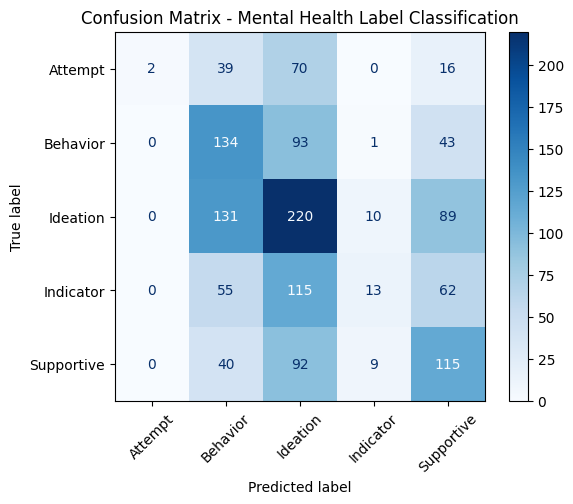

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_class_test, pred_class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Mental Health Label Classification")
plt.show()


Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_label_names, pred_label_names))

              precision    recall  f1-score   support

     Attempt       1.00      0.02      0.03       127
    Behavior       0.34      0.49      0.40       271
    Ideation       0.37      0.49      0.42       450
   Indicator       0.39      0.05      0.09       245
  Supportive       0.35      0.45      0.40       256

    accuracy                           0.36      1349
   macro avg       0.49      0.30      0.27      1349
weighted avg       0.42      0.36      0.32      1349



In [ ]:
import pandas as pd

# Get the first 10 samples (assuming X_test is not linked to original DataFrame)
sample_indices = np.arange(10)

# Manually get the post texts from df_expanded using stored test indices
# First: make sure we get test indices when splitting
from sklearn.model_selection import train_test_split

# Add index to track
df_expanded['original_index'] = df_expanded.index

X_train, X_test, y_score_train, y_score_test, y_class_train, y_class_test, train_idx, test_idx = train_test_split(
    X, y_score, y_class, df_expanded['original_index'].values, test_size=0.2, random_state=42
)

# Now fetch the first 10 test posts and predictions
sample_df = pd.DataFrame({
    'Post': df_expanded.loc[test_idx[:10], 'Clean_Post'].values,
    'True Label': label_encoder.inverse_transform(y_class_test[:10]),
    'Predicted Label': label_encoder.inverse_transform(np.argmax(pred_class_probs[:10], axis=1)),
    'True Score': y_score_test[:10],
    'Predicted Score': pred_scores[:10].flatten()
})

sample_df

,Post,True Label,Predicted Label,True Score,Predicted Score
0,Yeah she does want kids soon. I want kids too ...,Indicator,Ideation,0.13,0.479629
1,"Wow! Ok, this is intriguing stuff. his curator...",Ideation,Ideation,0.48,0.387423
2,Not going to tell you too much. Its not about ...,Ideation,Behavior,0.54,0.519257
3,Seriously shes not worth it. No matter how muc...,Supportive,Supportive,0.03,0.350800
4,I would imagine a lot of people here have been...,Ideation,Ideation,0.37,0.439579
5,This website has some good guidelines towards ...,Indicator,Ideation,0.18,0.431466
6,"then you have reason to live, them. Ask your s...",Ideation,Supportive,0.44,0.383013
7,You can call 911 and have them act as your own...,Indicator,Ideation,0.19,0.228535
8,It has taken me ten years to get this far. Peo...,Ideation,Behavior,0.38,0.459423
9,I hope you can find guidance from it.,Indicator,Ideation,0.19,0.413327


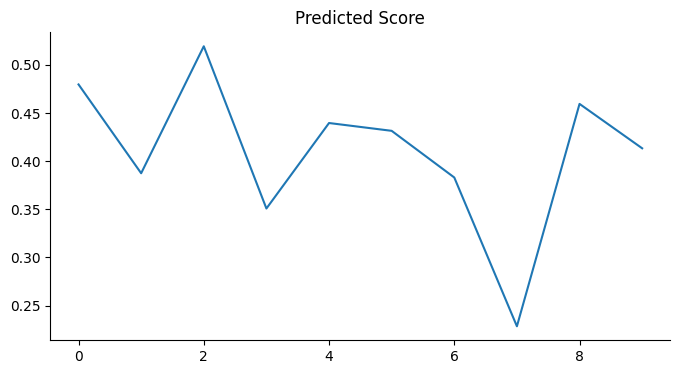

In [ ]:
# @title Predicted Score

from matplotlib import pyplot as plt
sample_df['Predicted Score'].plot(kind='line', figsize=(8, 4), title='Predicted Score')
plt.gca().spines[['top', 'right']].set_visible(False)